# KEN4157 - Reinforcement Learning - Cliff Walking Gymnasium
If you opened this notebook in Google Colab, we recommend to start by saving a copy of the notebook in your own Google Drive, such that you can save any of your changes and experiments.

## Installing & Importing Modules
We will start by installing importing some modules that will likely be useful for your assignment(s). This includes [Gymnasium](https://gymnasium.farama.org/), which is a framework containing many popular RL environments (a successor to the original Gym API from OpenAI).

In [1]:
!pip install gymnasium

import gymnasium as gym
import itertools
import math
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
import numpy as np
import seaborn as sns

from tqdm import tqdm

# Make plots look nice
sns.set()
sns.set_context("notebook")
sns.set_style("whitegrid")

## Setting up the Cliff Walking Environment
Here, we'll set up the Cliff Walking environment, and have a look at how to interact with it according to the Gym API.

**Optional**:
- For a description and documentation of the environment, see: https://gymnasium.farama.org/environments/toy_text/cliff_walking/
- For the implementation of the environment, see: https://github.com/Farama-Foundation/Gymnasium/blob/main/gymnasium/envs/toy_text/cliffwalking.py

In [2]:
env = gym.make('CliffWalking-v0')

action_space = env.action_space
obs_space = env.observation_space

# We'll define a few strings here, because proper names are sometimes nicer
# to work with (print) than arbitrary indices
ACTION_NAMES = ["Move Up", "Move Right", "Move Down", "Move Left"]

print(f"There are {action_space.n} different actions in this environment.")
for i in range(action_space.n):
  print(f"Action {i} = {ACTION_NAMES[i]}")
print(f"There are {obs_space.n} discrete states in this environment.")

There are 4 different actions in this environment.
Action 0 = Move Up
Action 1 = Move Right
Action 2 = Move Down
Action 3 = Move Left
There are 48 discrete states in this environment.


## Visualisation Code
Some functions here that let us nicely visualise Q-value tables for the Cliff Walking environment. No need to touch any of this, but you should run the code block, such that you can use the functions later on.

In [3]:
# Thanks to: https://stackoverflow.com/a/66050636/6735980
def triangulation_for_triheatmap(num_cols, num_rows):
    xv, yv = np.meshgrid(np.arange(-0.5, num_cols), np.arange(-0.5, num_rows))  # vertices of the little squares
    xc, yc = np.meshgrid(np.arange(0, num_cols), np.arange(0, num_rows))  # centers of the little squares
    x = np.concatenate([xv.ravel(), xc.ravel()])
    y = np.concatenate([yv.ravel(), yc.ravel()])
    cstart = (num_cols + 1) * (num_rows + 1)  # indices of the centers

    trianglesN = [(i + j * (num_cols + 1), i + 1 + j * (num_cols + 1), cstart + i + j * num_cols)
                  for j in range(num_rows) for i in range(num_cols)]
    trianglesE = [(i + 1 + j * (num_cols + 1), i + 1 + (j + 1) * (num_cols + 1), cstart + i + j * num_cols)
                  for j in range(num_rows) for i in range(num_cols)]
    trianglesS = [(i + 1 + (j + 1) * (num_cols + 1), i + (j + 1) * (num_cols + 1), cstart + i + j * num_cols)
                  for j in range(num_rows) for i in range(num_cols)]
    trianglesW = [(i + (j + 1) * (num_cols + 1), i + j * (num_cols + 1), cstart + i + j * num_cols)
                  for j in range(num_rows) for i in range(num_cols)]
    return [Triangulation(x, y, triangles) for triangles in [trianglesN, trianglesE, trianglesS, trianglesW]]

# Thanks to: https://stackoverflow.com/a/66050636/6735980
def create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left):
    NUM_COLS = 12
    NUM_ROWS = 4

    values = [q_vals_up, q_vals_right, q_vals_down, q_vals_left]
    triangul = triangulation_for_triheatmap(NUM_COLS, NUM_ROWS)
    fig, ax = plt.subplots()

    imgs = [ax.tripcolor(t, val.ravel(), cmap='RdYlGn',
                        norm=colors.SymLogNorm(linthresh=20.0, linscale=1.0,
                                               vmin=np.min(values),
                                               vmax=np.max(values), base=10)
                        )
            for t, val in zip(triangul, values)]
    cbar = fig.colorbar(imgs[0], ax=ax)

    ax.set_xticks(range(NUM_COLS))
    ax.set_yticks(range(NUM_ROWS))
    ax.invert_yaxis()
    ax.margins(x=0, y=0)
    ax.set_aspect('equal', 'box')  # square cells
    plt.tight_layout()
    plt.show()

def plot_returns_per_episode(returns_per_episode):
    fig, ax = plt.subplots()
    plt.plot([episode for episode in range(len(returns_per_episode))], returns_per_episode, label="Returns per Episode")
    ax.set_xlabel("Episode")
    ax.set_ylabel(f"Returns")
    ax.legend()
    plt.show()

## Random Value Function & Policy
In the below code block, we'll:
- fill up a Q(s, a) table with completely random numbers
- run through a bunch of steps with a random policy
- demonstrate how the above functions can be used to visualise this random Q-table and policy

Afterwards, you can implement your own (non-random) algorithms and use the plotting functions in the same way.

100%|██████████| 100000/100000 [00:00<00:00, 165557.46it/s]


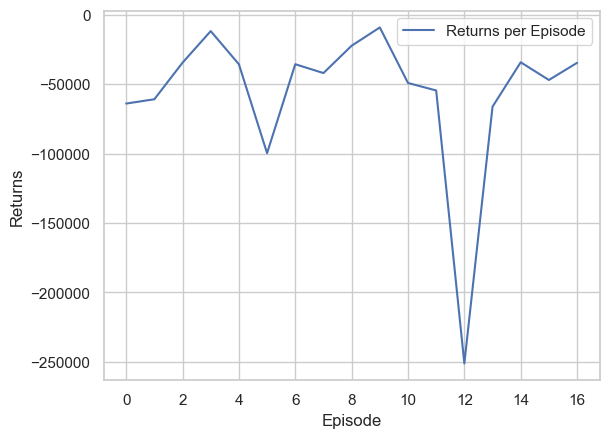

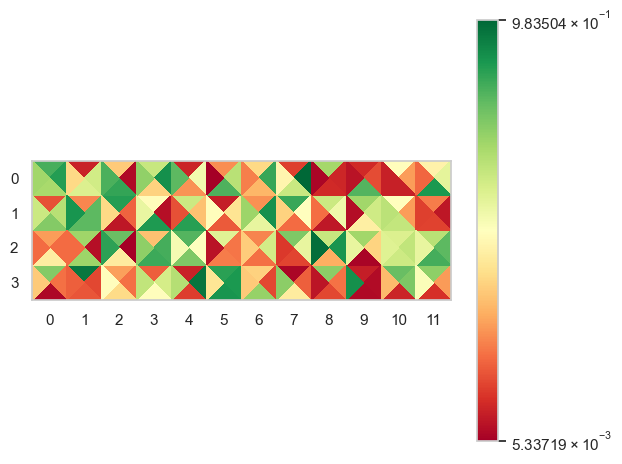

In [4]:
random_q_table = np.random.random((obs_space.n, action_space.n))
returns_per_episode = []

observation, info = env.reset()
current_episode_returns = 0.0

for step in tqdm(range(100_000)):
    action = action_space.sample()

    new_obs, reward, terminated, truncated, info = env.step(action)
    current_episode_returns = current_episode_returns + reward

    if terminated or truncated:
        # episode ended: store data and reset to new episode
        returns_per_episode.append(current_episode_returns)
        current_episode_returns = 0.0
        observation, info = env.reset()
    else:
        observation = new_obs

# Plot returns we got for each completed episode
plot_returns_per_episode(returns_per_episode)

# Plot heatmap from our Q-table (which in this case is just random numbers)
q_vals_up = random_q_table[:, 0]
q_vals_right = random_q_table[:, 1]
q_vals_down = random_q_table[:, 2]
q_vals_left = random_q_table[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)

## Your Code
Your own code should probably go below here!

### Implement a table-based on-policy Temporal Difference algorithm.
### Implement and show the difference between at least two exploration strategies.

In [5]:
def epsilon_greedy(q_values: np.ndarray, obs, epsilon: float) -> int:
    if np.random.random() < epsilon:
        return action_space.sample()
    else:
        return np.argmax(q_values[obs])

In [6]:
def boltzmann_policy(q_values: np.ndarray, obs, temperature: float):
    q_euler = np.exp(q_values[obs] / temperature)
    action_probs = q_euler / np.sum(q_euler)
    
    return np.random.choice(np.arange(len(action_probs)), p=action_probs)

In [7]:
def sarsa_epsilon(q_values: np.ndarray, episode_num: int, game_env: gym.Env, alpha: float=0.1, gamma: float=1.0, epsilon: float=0.1) -> (np.ndarray, list):
    episode_rewards = []
    for _ in tqdm(range(episode_num)):
        episode_reward = 0
        obs, info = game_env.reset()
        action = epsilon_greedy(q_values, obs, epsilon)
            
        while True:
            next_obs, reward, terminated, truncated, info = game_env.step(action)
            episode_reward += reward
            action_prime = epsilon_greedy(q_values, next_obs, epsilon)
            if terminated:
                value = 0
            else:
                value = q_values[next_obs, action_prime]

            q_values[obs, action] += alpha * (reward + gamma * value - q_values[obs, action])
            obs = next_obs
            action = action_prime
            
            if terminated or truncated:
                episode_rewards.append(episode_reward)
                break
    return q_values, episode_rewards

In [8]:
def sarsa_boltzmann(q_values: np.ndarray, episode_num: int, game_env: gym.Env, alpha: float=0.1, gamma: float=1.0, temperature: float=0.1) -> (np.ndarray, list):
    episode_rewards = []
    for _ in tqdm(range(episode_num)):
        episode_reward = 0
        obs, info = game_env.reset()
        action = boltzmann_policy(q_values, obs, temperature)

        while True:
            next_obs, reward, terminated, truncated, info = game_env.step(action)
            episode_reward += reward
            action_prime = boltzmann_policy(q_values, next_obs, temperature)
            if terminated:
                value = 0
            else:
                value = q_values[next_obs, action_prime]

            q_values[obs, action] += alpha * (reward + gamma * value - q_values[obs, action])
            obs = next_obs
            action = action_prime

            if terminated or truncated:
                episode_rewards.append(episode_reward)
                break
    return q_values, episode_rewards

In [9]:
q_values = np.zeros((obs_space.n, action_space.n))
episode_num = 10000
env = gym.make('CliffWalking-v0')

q_values, episode_rewards = sarsa_epsilon(q_values, episode_num, env, alpha=0.1, gamma=0.9, epsilon=0.1)

100%|██████████| 10000/10000 [00:01<00:00, 8598.17it/s]


### Show the influence of the exploration strategy on the performance of an on-policy RL algorithm.

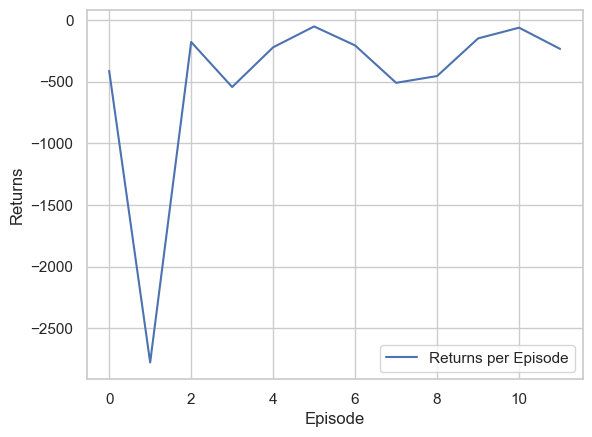

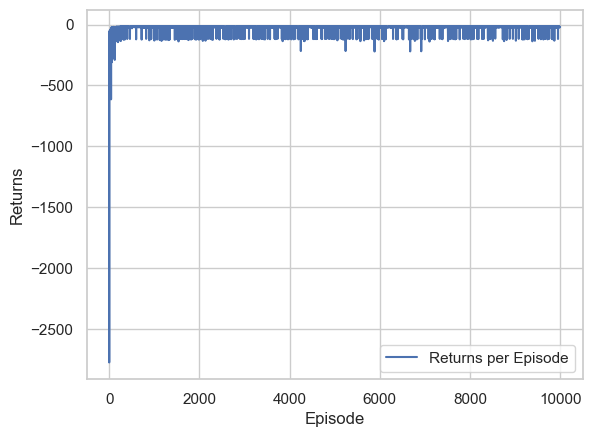

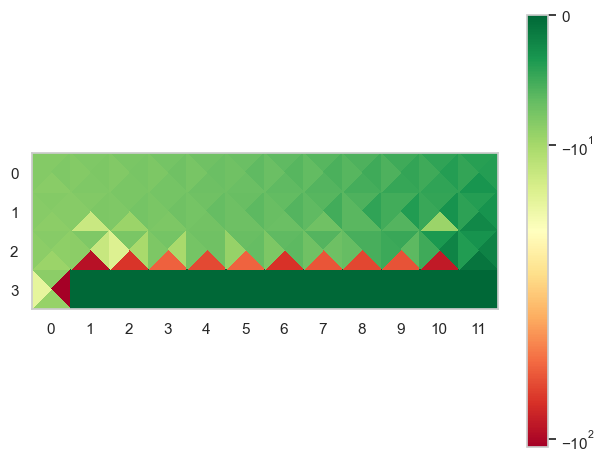

In [10]:
plot_returns_per_episode(episode_rewards[:12])
plot_returns_per_episode(episode_rewards)

q_vals_up = q_values[:, 0]
q_vals_right = q_values[:, 1]
q_vals_down = q_values[:, 2]
q_vals_left = q_values[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)

In [11]:
q_values = np.zeros((obs_space.n, action_space.n))
episode_num = 10000
env = gym.make('CliffWalking-v0')

q_values, episode_rewards = sarsa_boltzmann(q_values, episode_num, env, alpha=0.1, gamma=0.9, temperature=100)

100%|██████████| 10000/10000 [03:05<00:00, 53.88it/s]


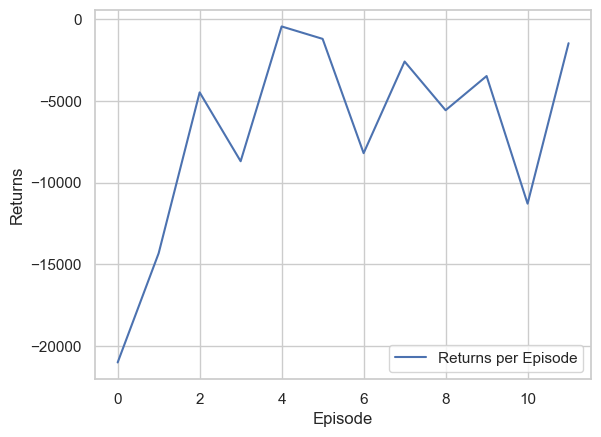

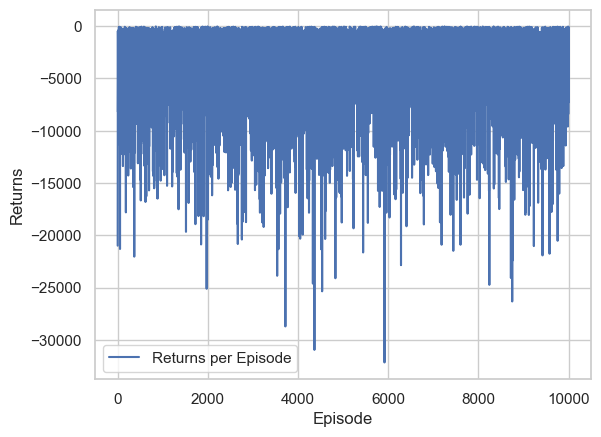

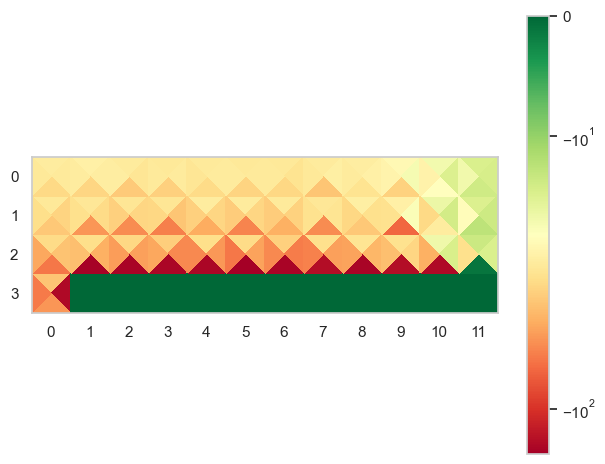

In [12]:
plot_returns_per_episode(episode_rewards[:12])
plot_returns_per_episode(episode_rewards)

q_vals_up = q_values[:, 0]
q_vals_right = q_values[:, 1]
q_vals_down = q_values[:, 2]
q_vals_left = q_values[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)

In [13]:
q_values = np.zeros((obs_space.n, action_space.n))
episode_num = 10000
env = gym.make('CliffWalking-v0')

q_values, episode_rewards = sarsa_boltzmann(q_values, episode_num, env, alpha=0.1, gamma=0.9, temperature=0.1)

100%|██████████| 10000/10000 [00:02<00:00, 3848.48it/s]


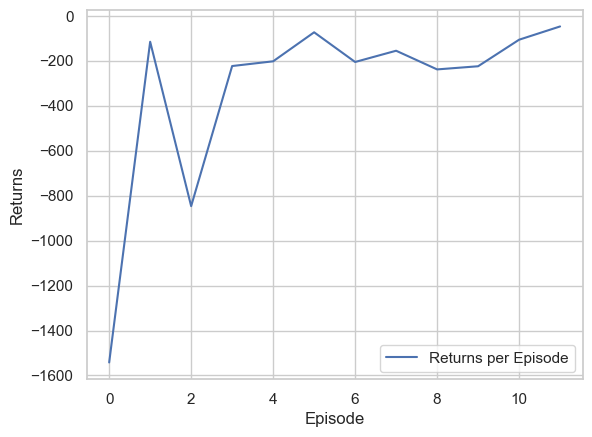

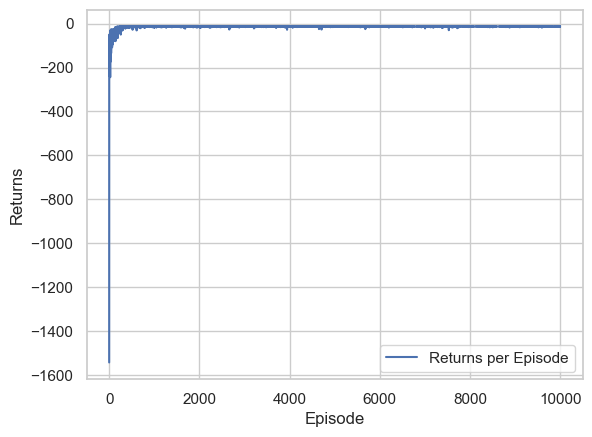

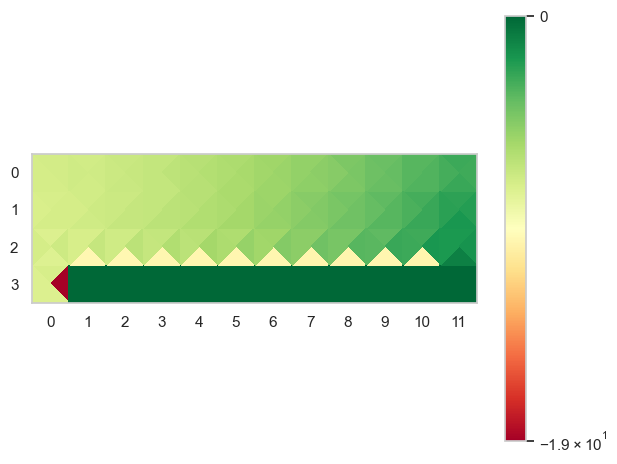

In [14]:
plot_returns_per_episode(episode_rewards[:12])
plot_returns_per_episode(episode_rewards)

q_vals_up = q_values[:, 0]
q_vals_right = q_values[:, 1]
q_vals_down = q_values[:, 2]
q_vals_left = q_values[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)

In [15]:
q_values = np.zeros((obs_space.n, action_space.n))
episode_num = 10000
env = gym.make('CliffWalking-v0')

q_values, episode_rewards = sarsa_boltzmann(q_values, episode_num, env, alpha=0.1, gamma=0.9, temperature=0.9)

100%|██████████| 10000/10000 [00:07<00:00, 1387.57it/s]


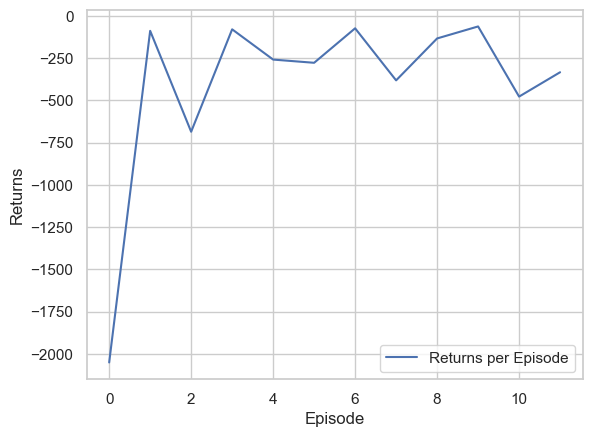

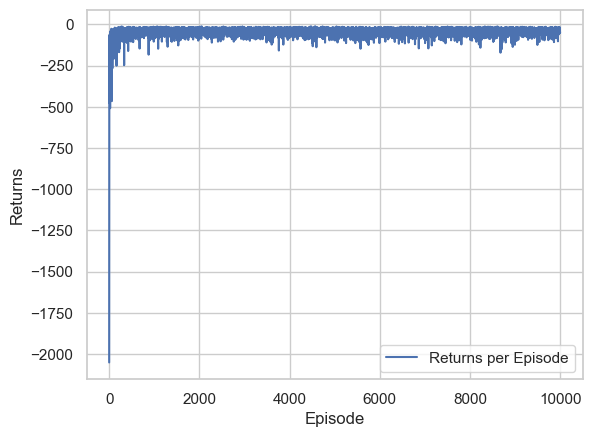

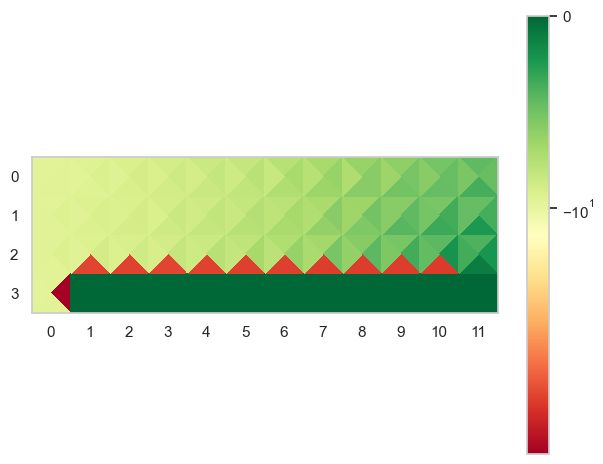

In [16]:
plot_returns_per_episode(episode_rewards[:12])
plot_returns_per_episode(episode_rewards)

q_vals_up = q_values[:, 0]
q_vals_right = q_values[:, 1]
q_vals_down = q_values[:, 2]
q_vals_left = q_values[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)

### Illustrate the difference between on-policy and off-policy learning algorithms on a suitable task. 

In [17]:
def q_learning(q_values: np.ndarray, episode_num: int, game_env: gym.Env, alpha: float=0.1, gamma: float=1.0, epsilon: float=0.1) -> (np.ndarray, list):
    episode_rewards = []
    for _ in tqdm(range(episode_num)):
        episode_reward = 0
        obs, info = game_env.reset()
        while True:
            if np.random.random() < epsilon:
                action = action_space.sample()
            else:
                action = np.argmax(q_values[obs])

            next_obs, reward, terminated, truncated, info = game_env.step(action)
            episode_reward += reward

            if terminated:
                value = 0
                episode_rewards.append(episode_reward)
            else:
                value = np.max(q_values[next_obs])

            q_values[obs, action] += alpha * (reward + gamma * value - q_values[obs, action])
            obs = next_obs
            if terminated or truncated:
                break
    return q_values, episode_rewards

In [18]:
q_values_1 = np.zeros((obs_space.n, action_space.n))
episode_num = 10000
env = gym.make('CliffWalking-v0')

q_values_1, episode_rewards_1 = q_learning(q_values_1, episode_num, env, alpha=0.1, gamma=0.9, epsilon=0.1)

100%|██████████| 10000/10000 [00:01<00:00, 6775.40it/s]


In [19]:
q_values_2 = np.zeros((obs_space.n, action_space.n))
episode_num = 10000
env = gym.make('CliffWalking-v0')

q_values_2, episode_rewards_2 = sarsa_epsilon(q_values_2, episode_num, env, alpha=0.1, gamma=0.9, epsilon=0.1)

100%|██████████| 10000/10000 [00:01<00:00, 8415.95it/s]


#### Off-policy

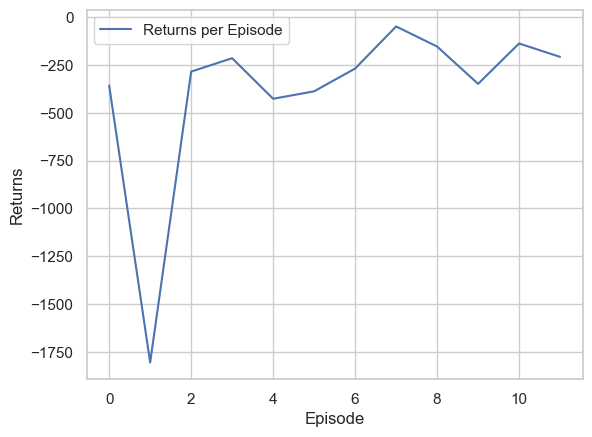

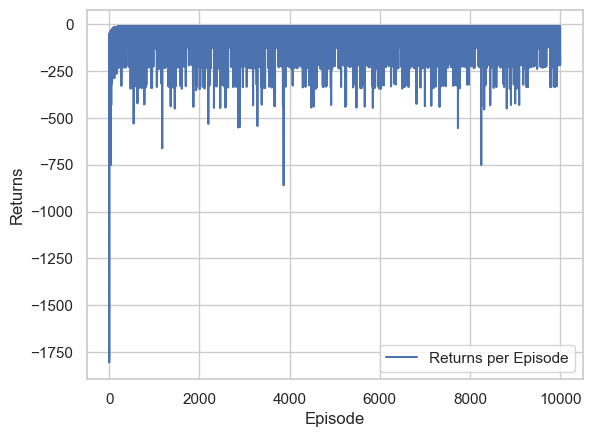

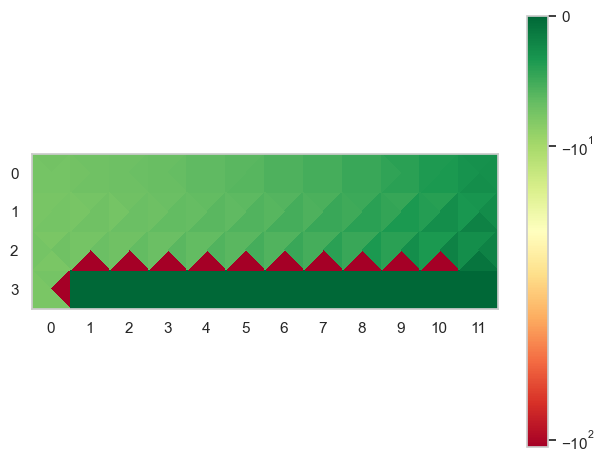

In [20]:
plot_returns_per_episode(episode_rewards_1[:12])
plot_returns_per_episode(episode_rewards_1)

q_vals_up = q_values_1[:, 0]
q_vals_right = q_values_1[:, 1]
q_vals_down = q_values_1[:, 2]
q_vals_left = q_values_1[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)

#### On-policy

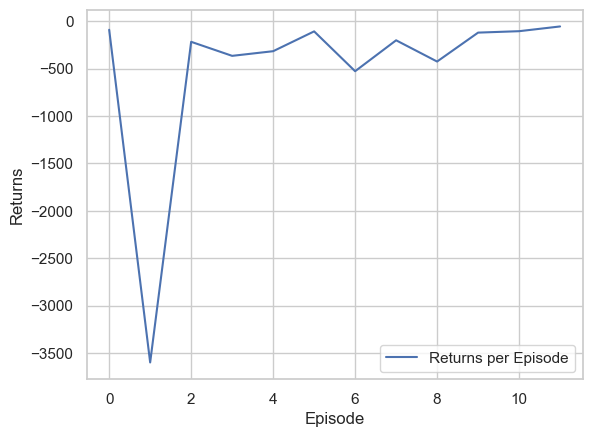

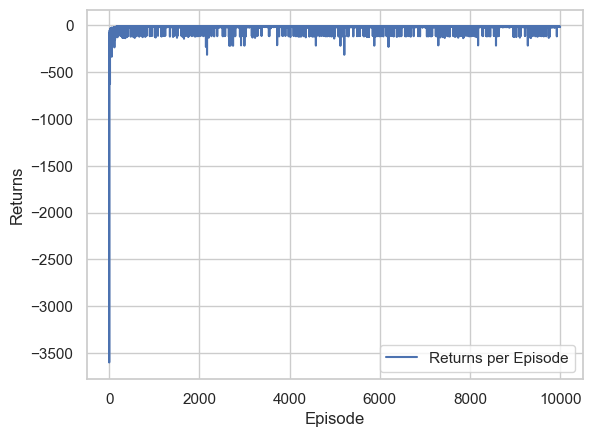

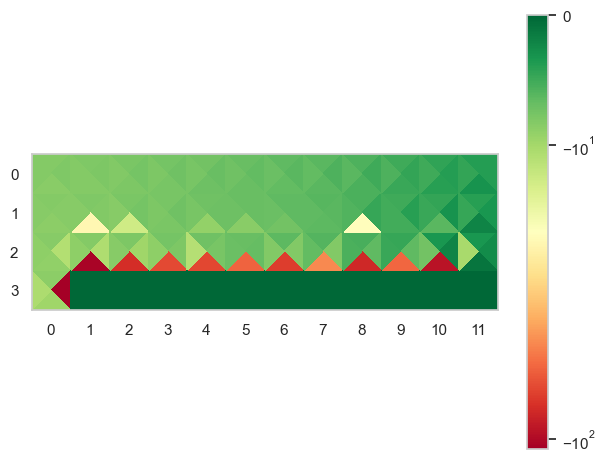

In [21]:
plot_returns_per_episode(episode_rewards_2[:12])
plot_returns_per_episode(episode_rewards_2)

q_vals_up = q_values_2[:, 0]
q_vals_right = q_values_2[:, 1]
q_vals_down = q_values_2[:, 2]
q_vals_left = q_values_2[:, 3]
create_qvals_heatmap(q_vals_up, q_vals_right, q_vals_down, q_vals_left)